In [18]:
import json
import altair as alt
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mannwhitneyu

df=pd.read_csv('final_stats.csv')

In [5]:
alt.themes.enable('default')

with open('dark_theme.json', 'r') as file:
    dark_theme = json.load(file)

def my_theme():
    dark_theme_config = {
    "config": {
        "view": {"fill": "black"},
        "background": "black",
        "axis": {"labelColor": "white", "titleColor": "white"},
        "text": {"color": "white"}
    }
}
    return dark_theme_config

alt.themes.register('my_theme', my_theme)
alt.themes.enable('my_theme')

ThemeRegistry.enable('my_theme')

In [6]:
def att_vs_winrate(df, target_col, target_col2):

    color_map = {'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'}
    df['Color'] = df['Primary Attribute'].map(color_map)

    fig = px.box(df, y=target_col, points='all', title='Heroes by {} vs {}.'.format(target_col2, target_col),
                 hover_data=['Name', target_col],
                 color='Primary Attribute', color_discrete_map=color_map)
    
    fig.update_layout(template='plotly_dark', yaxis_title=target_col)

    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Immortal Win Rate: %{y}')

    fig.show()

att_vs_winrate (df, 'Immortal Win Rate', 'Primary Attribute')

In [7]:
def win_rate_picks_correlation(df, target_col, target_col2):
    correlation = df[target_col].corr(df[target_col2])

    fig = px.scatter(df, x=target_col, y=target_col2,
                     labels={target_col: target_col, target_col2: target_col2},
                     title=f'Win Rate vs. Pick Rate ({target_col}) - Correlation: {correlation:.2f}',
                     template='plotly_dark',
                     color='Primary Attribute',
                     color_discrete_map={'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'},
                     hover_data=['Name'],
                     size='Immortal Wins', size_max=30)

    fig.update_layout(xaxis_title='Immortal Picks', yaxis_title='Immortal Win Rate')

    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Immortal Picks %{x} <br>Immortal Win Rate: %{y}')

    fig.show()

win_rate_picks_correlation(df, 'Immortal Picks', 'Immortal Win Rate')


In [8]:
top_10_df = df.groupby(['Primary Attribute']).apply(lambda x: x.nlargest(10, 'Immortal Win Rate')).reset_index(drop=True)
top_10_df = top_10_df.sort_values(by=['Primary Attribute', 'Immortal Win Rate'], ascending=[True, False])

chart = alt.Chart(top_10_df).mark_bar().encode(

    alt.X('Immortal Win Rate:Q', title='Immortal Win Rate'),
    alt.Y('Name:N', title='Hero', sort=alt.EncodingSortField(field='Primary Attribute')),
    
    color=alt.Color('Primary Attribute:N',
                    scale=alt.Scale(domain=['str', 'int', 'agi', 'all'], range=['red', 'blue', 'green', 'purple']),
                    legend=None),

).properties(
    width=600,
    height=400,
    title='Top 10 Heroes Win Rate in Each Primary Attribute (Grouped Bar Chart)'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

chart

alt.Chart(...)

In [9]:
def type_corr_winrate(df, target_col, feature_col1, feature_col2):
    
    color_map = {'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'}
    df['Color'] = df[feature_col1].map(color_map)
    fig = px.box(df, x=feature_col2, y=target_col, points='all', title=f'{feature_col2}, {target_col} Correlation.',
                 hover_data=['Name', target_col],
                 color=feature_col1, color_discrete_map=color_map)
    
    fig.update_layout(template='plotly_dark', yaxis_title=target_col)

    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Immortal Win Rate: %{y}')
    
    fig.show()

type_corr_winrate (df, 'Immortal Win Rate', 'Primary Attribute','attack_type')

In [16]:
filtered_df = df[df['attack_type'] != 'int']

label_encoder = LabelEncoder()

df['attack_type_encoded'] = label_encoder.fit_transform(df['attack_type'])

correlation = df['attack_type_encoded'].corr(df['Immortal Win Rate'])

print(f"Attack Type, Immortal Win Rate Correlation: {correlation}")



Attack Type, Immortal Win Rate Correlation: -0.0054242138578154886


In [19]:
filtered_df = df [(df['attack_type'] != 'int') & (df ['attack_type'] != 'str')]

melee_data = filtered_df[filtered_df['attack_type'] == 'Melee'] ['Immortal Win Rate']
ranged_data = filtered_df[filtered_df['attack_type'] == 'Ranged'] ['Immortal Win Rate']

statistic, p_value = mannwhitneyu(melee_data, ranged_data)

alpha = 0.01

print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between Melee and Ranged heroes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between Melee and Ranged heroes.")

Mann-Whitney U Statistic: 1816.0
P-value: 0.604802054088611
Fail to reject the null hypothesis: There is no significant difference between Melee and Ranged heroes.


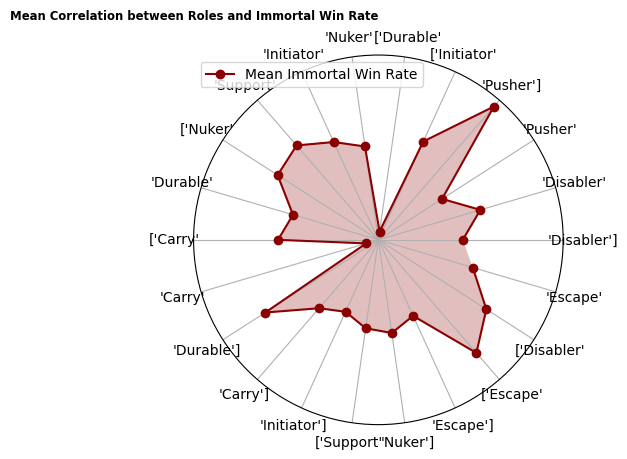

In [4]:
role_win_rates = {}

for _, row in df.iterrows():
    roles = row['roles'].split(', ')
    win_rate = row['Immortal Win Rate']

    for role in roles:
        role = role.strip()
        if role not in role_win_rates:
            role_win_rates[role] = {'win_rates': [], 'count': 0}
        role_win_rates[role]['win_rates'].append(win_rate)
        role_win_rates[role]['count'] += 1

unique_roles_set = set(role for roles in df['roles'] for role in roles.split(', '))
unique_roles = list(unique_roles_set)

mean_win_rates = [sum(role_win_rates[role]['win_rates']) / role_win_rates[role]['count']
                  if role in role_win_rates else 0 for role in unique_roles]

num_unique_roles = len(unique_roles)

theta = np.linspace(0, 2*np.pi, num_unique_roles, endpoint=False)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

ax.set_xticks(theta)
ax.set_xticklabels(unique_roles)

ax.plot(theta, mean_win_rates, color='Darkred', marker='o', label='Mean Immortal Win Rate')
ax.fill(theta, mean_win_rates, facecolor='Darkred', alpha=0.25)

ax.set_title('Mean Correlation between Roles and Immortal Win Rate', weight='bold', size='small', position=(0.5, 1.1),
             horizontalalignment='right', verticalalignment='bottom')
ax.legend(loc='upper left')

plt.show()


In [2]:
cross_tab = pd.crosstab(df['roles'], df['Immortal Win Rate'])

chi2 = chi2_contingency(cross_tab)[0]
print('Chi2: ', chi2)

num_obs = np.sum(cross_tab)
print('Observers Number: ', num_obs)

min_dim = min(cross_tab.shape) - 1
print('Minimum Dimension: ', min_dim)

cramer_v = np.sqrt(chi2 / (num_obs * min_dim))
print(f"Cramér's V: {cramer_v}")

Chi2:  11650.833333333338
Observers Number:  Immortal Win Rate
39.45    1
42.56    1
43.55    1
43.89    1
44.52    1
        ..
54.62    1
55.34    1
55.55    1
56.10    1
56.85    1
Length: 115, dtype: int64
Minimum Dimension:  101
Cramér's V: Immortal Win Rate
39.45    10.740335
42.56    10.740335
43.55    10.740335
43.89    10.740335
44.52    10.740335
           ...    
54.62    10.740335
55.34    10.740335
55.55    10.740335
56.10    10.740335
56.85    10.740335
Length: 115, dtype: float64


In [4]:
role_groups = [df[df['roles'] == role]['Immortal Win Rate'] for role in df['roles'].unique()]

f_statistic, p_value = f_oneway(*role_groups)

print(f'F-statistic: {f_statistic}')
print(f'p-value: {p_value}')

F-statistic: 0.6206562369351009
p-value: 0.9416960008782077


In [ ]:
# No Correlation whatsoever between heroes stats and Win Rate in Immortal bracket, it's all about player skill level.